### Imports

In [ ]:
# imports
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report,accuracy_score,roc_auc_score


### Reading the credit card dataset

This dataset has 31 variables:
- Time - time of transaction
- V1-28 - PCAs
- Amount - amount of money in transaction
- Class - 0 or 1, where 0 is not a fraud and 1 is a fraud

In [22]:
# reading data
data = pd.read_csv('creditcard.csv')
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### The shape of the dataset is 28481 by 31.

In [23]:
data1= data.sample(frac = 0.1,random_state=1)
data1.shape

(28481, 31)

Determine the number of fraud and valid transactions in the entire dataset

Notice that there are significantly more normal transactions than fraud transactions.  The fraud transactions are the anomolies, which is what we are trying to detect.

Text(0, 0.5, 'Frequency')

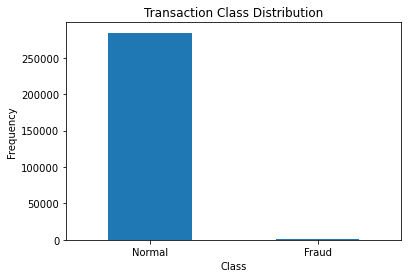

In [24]:

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), ["Normal", "Fraud"])
plt.xlabel("Class")
plt.ylabel("Frequency")

Use binary classification to break transactions into two groups.  Any observation with class 0 is considered normal and any observation with class 1 is considered fraud.

In [25]:
#Assigning the transaction class "0 = NORMAL  & 1 = FRAUD"
Normal = data[data['Class']==0]
Fraud = data[data['Class']==1]

Partitioning the dataset 
- X is all columns except the class column
- Y is the class column which will be used as the predictor

In [26]:
#Get all the columns from the dataframe
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))

(28481, 30)
(28481,)


### Isolation Forest

Now we will define our isolation forest model. The main idea of isolation forest is to use trees to essentially "isolate" anomolies.  Anomolies should not take many trees to be isolated from the rest of the dataset. This isolation forest model is taken from sklearn.  The following parameters are:
- n_estimators : the number of base estimators in ensemble
- max_samples: number of samples to draw from X to train eachbase estimator
- contamination: proportion of outliers in dataset
- random_state: controls pseudo-randomness of selection of feature and split values
- verbose: controls verbosity of tree building process

In [31]:
# isolation forest
Fraud = data1[data1['Class']==1]
Valid = data1[data1['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))
iforest = IsolationForest(n_estimators=100, max_samples=len(X), contamination=outlier_fraction,random_state=state, verbose=0)

In [32]:
# Isolation forest model
n_outliers = len(Fraud)
iforest.fit(X)
scores_prediction = iforest.decision_function(X)
y_pred = iforest.predict(X)

In [33]:
# reshape the prediction to 0 and 1
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()


In [34]:
# accuracy report
print("Isolation Forest:", n_errors)
print("Accuracy Score: ", accuracy_score(Y, y_pred))
print("ROC curve: ", roc_auc_score(Y, y_pred))
print("Classification Report :")
print(classification_report(Y,y_pred))

Isolation Forest: 73
Accuracy Score:  0.9974368877497279
ROC curve:  0.632002385929048
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.26      0.27      0.26        49

    accuracy                           1.00     28481
   macro avg       0.63      0.63      0.63     28481
weighted avg       1.00      1.00      1.00     28481

